In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

In [21]:
data=pd.read_excel("Impact of Discount on customer lifetime.xlsx",skiprows=2,usecols="B:E")# import the excel file 
data.head(5)

,Discount %,High value,Mid Value,Low value
0,0.01,0.0,0.25,0.75
1,0.02,0.0,1.00,1.00
2,0.03,0.2,2.00,2.00
3,0.04,0.5,4.00,3.00
4,0.05,1.0,4.50,4.00


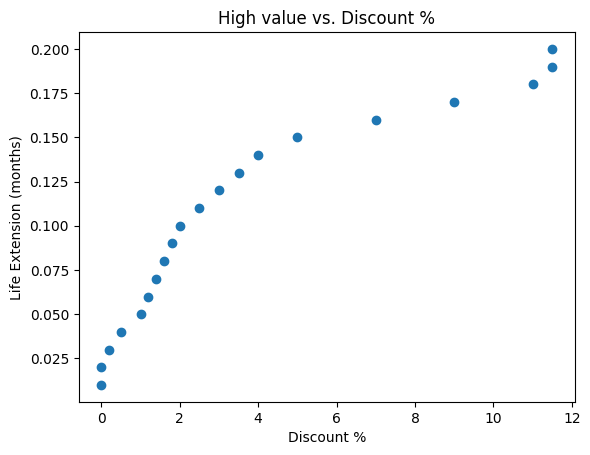

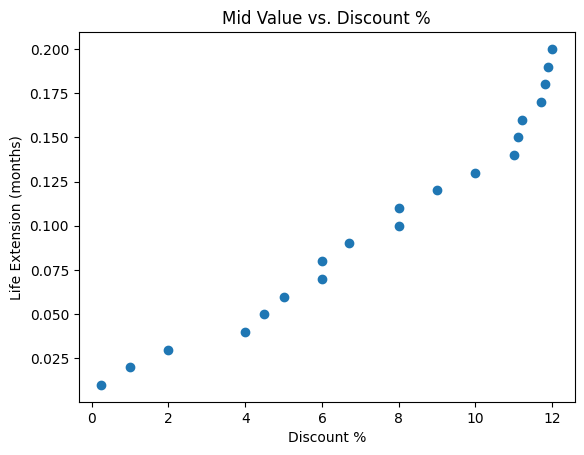

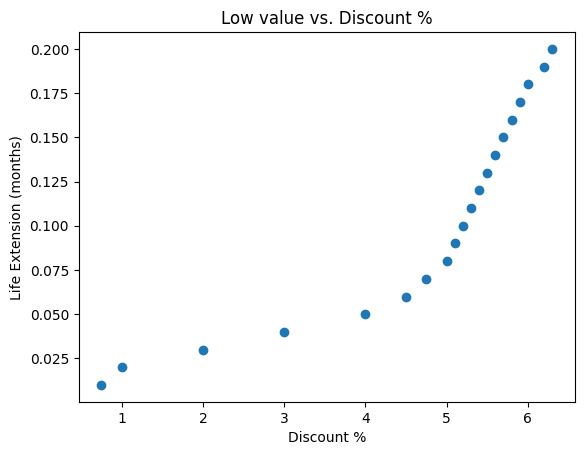

In [28]:
#Print the Scatter plots for the 3 segments.
for i in range(1, 4):
    plt.scatter(data[data.columns[i]], data['Discount %'])
    plt.title(f"{data.columns[i]} vs. Discount %")
    plt.xlabel('Discount %')
    plt.ylabel('Life Extension (months)')
    plt.show()

### Predicting the Lifetime extension for customers

In [63]:
new_discounts = np.arange(1, 21, 1).reshape(-1, 1)  # Now goes from 0% to 20%

new_discounts = np.linspace(1, 20, 20).reshape(-1, 1)  # Includes 20%, 21 numbers from 0 to 20

In [66]:
def fit_polynomial_regression(X, y, degree=3):
    # Transforming the input data to include polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    # Fitting the linear regression model on transformed features
    model = LinearRegression().fit(X_poly, y)
    
    # Predicting using the model to calculate RMSE
    y_pred = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    return model, rmse, poly_features

# Fit the model for each customer segment
model_high, rmse_high, poly_features_high = fit_polynomial_regression(data[['Discount %']], data['High value'] )
model_mid, rmse_mid, poly_features_mid = fit_polynomial_regression(data[['Discount %']], data['Mid Value'] )
model_low, rmse_low, poly_features_low = fit_polynomial_regression(data[['Discount %']], data['Low value'] )

# Printing RMSE values for each model
print(f'RMSE for High Value Customers: {rmse_high}')
print(f'RMSE for Mid Value Customers: {rmse_mid}')
print(f'RMSE for Low Value Customers: {rmse_low}')

RMSE for High Value Customers: 0.593718702235923
RMSE for Mid Value Customers: 0.37687865681296606
RMSE for Low Value Customers: 0.18998637405530927


In [96]:
model_high.intercept_

-0.1665221878225025

In [67]:
def predict_extensions(model, poly_features, new_discounts):
    # Transform new discounts to polynomial features
    new_discounts_poly = poly_features.transform(new_discounts)
    # Use the model to predict extensions for these transformed features
    return model.predict(new_discounts_poly)

# Predict extensions for the new discounts
predicted_extensions_high = predict_extensions(model_high, poly_features_high, data[['Discount %']])
predicted_extensions_mid = predict_extensions(model_mid, poly_features_mid, data[['Discount %']])
predicted_extensions_low = predict_extensions(model_low, poly_features_low, data[['Discount %']])

In [68]:
# Function to print predicted extensions for new discounts
def print_predicted_extensions(new_discounts, predicted_extensions, segment_name):
    print(f"Predicted Extensions for {segment_name} Segment:")
    for discount, extension in zip(new_discounts.flatten(), predicted_extensions):
        print(f"Discount {discount}%: {extension:.2f} months")
    print("\n")  # Just for better spacing

# Print the predicted lifetime extensions for each segment
print_predicted_extensions(new_discounts, predicted_extensions_high, "High Value")
print_predicted_extensions(new_discounts, predicted_extensions_mid, "Mid Value")
print_predicted_extensions(new_discounts, predicted_extensions_low, "Low Value")

Predicted Extensions for High Value Segment:
Discount 1.0%: 0.03 months
Discount 2.0%: 0.20 months
Discount 3.0%: 0.36 months
Discount 4.0%: 0.52 months
Discount 5.0%: 0.69 months
Discount 6.0%: 0.89 months
Discount 7.0%: 1.12 months
Discount 8.0%: 1.39 months
Discount 9.0%: 1.73 months
Discount 10.0%: 2.14 months
Discount 11.0%: 2.64 months
Discount 12.0%: 3.23 months
Discount 13.0%: 3.93 months
Discount 14.0%: 4.75 months
Discount 15.0%: 5.71 months
Discount 16.0%: 6.81 months
Discount 17.0%: 8.06 months
Discount 18.0%: 9.49 months
Discount 19.0%: 11.10 months
Discount 20.0%: 12.90 months


Predicted Extensions for Mid Value Segment:
Discount 1.0%: 0.39 months
Discount 2.0%: 1.33 months
Discount 3.0%: 2.25 months
Discount 4.0%: 3.15 months
Discount 5.0%: 4.03 months
Discount 6.0%: 4.88 months
Discount 7.0%: 5.71 months
Discount 8.0%: 6.50 months
Discount 9.0%: 7.26 months
Discount 10.0%: 7.97 months
Discount 11.0%: 8.65 months
Discount 12.0%: 9.27 months
Discount 13.0%: 9.84 months
D

### Finding the optimal solution

In [97]:
# Define your customer segments, discount levels, average revenues, original lifetimes, and segment sizes
segments = ['High', 'Medium', 'Low']
discount_levels = list(range(1, 21))  # 1% to 20% discounts
AR = {'High': 60, 'Medium': 50, 'Low': 40}  # Average monthly revenue
LT = {'High': 14, 'Medium': 12, 'Low': 6}  # Original lifetime in months
segment_customers = {'High': 40000, 'Medium': 25000, 'Low': 10000}  # Customers in each segment
intercepts = {'High': model_high.intercept_, 'Medium': model_mid.intercept_, 'Low': model_low.intercept_}

# Convert lists to dictionaries
predicted_extensions = {
    'High': {discount_levels[i]: predicted_extensions_high[i] for i in range(len(discount_levels))},
    'Medium': {discount_levels[i]: predicted_extensions_mid[i] for i in range(len(discount_levels))},
    'Low': {discount_levels[i]: predicted_extensions_low[i] for i in range(len(discount_levels))}
}



In [98]:
# Initialize the model
m = Model("RevenueMaximization")

# Decision Variables: number of customers in each segment offered each discount level
x = m.addVars(segments, discount_levels, vtype=GRB.INTEGER, name="x")

# Objective Function: Maximize total revenue considering average revenue, original lifetime, and predicted extensions
m.setObjective(sum(x[s, d] * AR[s] * (LT[s] + predicted_extensions[s][d]+intercepts[s]) for s in segments for d in discount_levels), GRB.MAXIMIZE)



In [99]:
# Constraints

# 1. Limit discounts to no more than 20% of the total customer base
total_customers = sum(segment_customers.values())
m.addConstr(sum(x[s, d] for s in segments for d in discount_levels) <= 0.20 * total_customers, "DiscountLimitation")

# 2. Ensure the total customers in each segment receiving discounts does not exceed the segment size
for s in segments:
    m.addConstr(sum(x[s, d] for d in discount_levels) <= segment_customers[s], f"CustomerLimit_{s}")



In [100]:
# Solve the model
m.optimize()



Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i9-12900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x7fa23932
Variable types: 0 continuous, 60 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 4e+04]
Found heuristic solution: objective 1.247709e+07
Presolve removed 4 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 2: 2.4057e+07 1.24771e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.405700975993e+07, best bound 2.405700975993e+07, gap 0.0000%


In [101]:
# Extract and print the solution
if m.status == GRB.OPTIMAL:
    solution = m.getAttr('X', x)
    for s in segments:
        for d in discount_levels:
            if solution[s, d] >= 0:
                print(f"Segment: {s}, Discount {d}%, Customers: {solution[s, d]}")
else:
    print("Optimal solution was not found.")

Segment: High, Discount 1%, Customers: -0.0
Segment: High, Discount 2%, Customers: -0.0
Segment: High, Discount 3%, Customers: -0.0
Segment: High, Discount 4%, Customers: -0.0
Segment: High, Discount 5%, Customers: -0.0
Segment: High, Discount 6%, Customers: -0.0
Segment: High, Discount 7%, Customers: -0.0
Segment: High, Discount 8%, Customers: -0.0
Segment: High, Discount 9%, Customers: -0.0
Segment: High, Discount 10%, Customers: -0.0
Segment: High, Discount 11%, Customers: -0.0
Segment: High, Discount 12%, Customers: -0.0
Segment: High, Discount 13%, Customers: -0.0
Segment: High, Discount 14%, Customers: -0.0
Segment: High, Discount 15%, Customers: -0.0
Segment: High, Discount 16%, Customers: -0.0
Segment: High, Discount 17%, Customers: -0.0
Segment: High, Discount 18%, Customers: -0.0
Segment: High, Discount 19%, Customers: -0.0
Segment: High, Discount 20%, Customers: 15000.0
Segment: Medium, Discount 1%, Customers: -0.0
Segment: Medium, Discount 2%, Customers: -0.0
Segment: Mediu